In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install segmentation-models-pytorch

In [3]:

# Paths inside your Google Drive
image_dir = "/content/drive/MyDrive/DATASPLIT/TRAIN/NIR"
mask_dir  = "/content/drive/MyDrive/DATASPLIT/TRAIN/MASK"

In [4]:
import os, cv2
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from tqdm import tqdm
import segmentation_models_pytorch as smp

In [5]:
class VegetationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_name = self.images[idx].replace("NIR", "MASK").replace(".TIF", ".png")
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            raise FileNotFoundError(f"Missing file at {img_path} or {mask_path}")

        image = image.astype("float32") / 255.0
        mask = mask.astype("float32") / 255.0

        # Add channel dim for albumentations

        image = image.astype("float32")
        mask = mask.astype("float32")
        image = image[..., np.newaxis]
        mask = mask[..., np.newaxis]

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        # Final: [1, H, W]
        return image.float(), mask.permute(2, 0, 1).float()



# Augmentations
fixed_height = 256
fixed_width = 256

# transform = A.Compose([
#     A.Resize(256, 256),
#     A.HorizontalFlip(p=0.5),
#     A.RandomRotate90(p=0.5),
#     A.ShiftScaleRotate(p=0.4),
#     A.RandomBrightnessContrast(p=0.2),
#     A.Normalize(mean=(0.5,), std=(0.5,)),
#     ToTensorV2(),
# ])
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(p=0.5, shift_limit=0.1, scale_limit=0.1, rotate_limit=15),
    A.Normalize(mean=0.0, std=1.0),
    ToTensorV2()
])

In [6]:
def iou(pred, target):
    pred = pred > 0.5
    target = target > 0.5
    intersection = (pred & target).float().sum((1, 2))
    union = (pred | target).float().sum((1, 2))
    return (intersection + 1e-6) / (union + 1e-6)

def pixel_accuracy(pred, mask):
    pred = pred > 0.5
    correct = (pred == mask).float()
    return correct.mean()


In [7]:
import torch.nn as nn
import torch

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.dconv_down1 = DoubleConv(1, 64)
        self.dconv_down2 = DoubleConv(64, 128)
        self.dconv_down3 = DoubleConv(128, 256)
        self.dconv_down4 = DoubleConv(256, 512)

        self.maxpool = nn.MaxPool2d(2)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

        self.dconv_up3 = DoubleConv(256 + 512, 256)
        self.dconv_up2 = DoubleConv(128 + 256, 128)
        self.dconv_up1 = DoubleConv(64 + 128, 64)

        self.conv_last = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)
        return out  # NOTE: don't apply sigmoid here (handled in loss/metrics)


In [8]:
import torch.nn as nn
import torch

def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = 1 - ((2. * intersection + smooth) /
               (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth))
    return loss.mean()

class ComboLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, pred, target):
        bce = self.bce(pred, target)
        dice = dice_loss(torch.sigmoid(pred), target)
        return bce + dice

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = smp.Unet(encoder_name="resnet34", in_channels=1, classes=1).to(device)
criterion = ComboLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Dataset & Loader
train_dataset = VegetationDataset(image_dir, mask_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataset = VegetationDataset("/content/drive/MyDrive/DATASPLIT/VAL/NIR", "/content/drive/MyDrive/DATASPLIT/VAL/MASK", transform=transform)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Train
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")

    for imgs, masks in loop:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = torch.sigmoid(model(imgs))
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    print(f"✅ Epoch {epoch+1}: Avg Loss = {epoch_loss / len(train_loader):.4f}")
    model.eval()
    val_iou, val_acc = 0, 0

    with torch.no_grad():
        for val_imgs, val_masks in val_loader:
            val_imgs, val_masks = val_imgs.to(device), val_masks.to(device)
            val_preds = torch.sigmoid(model(val_imgs))
            val_iou += iou(val_preds, val_masks).mean().item()
            val_acc += pixel_accuracy(val_preds, val_masks).item()

    val_iou /= len(val_loader)
    val_acc /= len(val_loader)
    print(f"📊 Val -> IoU: {val_iou:.4f}, Pixel Acc: {val_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Epoch [1/100]: 100%|██████████| 45/45 [02:29<00:00,  3.32s/it, loss=0.718]


✅ Epoch 1: Avg Loss = 0.7958
📊 Val -> IoU: 0.7646, Pixel Acc: 0.7646


Epoch [2/100]: 100%|██████████| 45/45 [00:14<00:00,  3.08it/s, loss=0.87]


✅ Epoch 2: Avg Loss = 0.7454
📊 Val -> IoU: 0.7650, Pixel Acc: 0.7677


Epoch [3/100]: 100%|██████████| 45/45 [00:14<00:00,  3.06it/s, loss=0.731]


✅ Epoch 3: Avg Loss = 0.7315
📊 Val -> IoU: 0.8053, Pixel Acc: 0.8612


Epoch [4/100]: 100%|██████████| 45/45 [00:14<00:00,  3.09it/s, loss=0.706]


✅ Epoch 4: Avg Loss = 0.7265
📊 Val -> IoU: 0.8040, Pixel Acc: 0.8667


Epoch [5/100]: 100%|██████████| 45/45 [00:17<00:00,  2.52it/s, loss=0.766]


✅ Epoch 5: Avg Loss = 0.7212
📊 Val -> IoU: 0.8313, Pixel Acc: 0.8753


Epoch [6/100]: 100%|██████████| 45/45 [00:17<00:00,  2.54it/s, loss=0.678]


✅ Epoch 6: Avg Loss = 0.7231
📊 Val -> IoU: 0.8352, Pixel Acc: 0.8682


Epoch [7/100]: 100%|██████████| 45/45 [00:14<00:00,  3.06it/s, loss=0.692]


✅ Epoch 7: Avg Loss = 0.7183
📊 Val -> IoU: 0.8360, Pixel Acc: 0.8756


Epoch [8/100]: 100%|██████████| 45/45 [00:14<00:00,  3.08it/s, loss=0.82]


✅ Epoch 8: Avg Loss = 0.7213
📊 Val -> IoU: 0.8319, Pixel Acc: 0.8811


Epoch [9/100]: 100%|██████████| 45/45 [00:16<00:00,  2.77it/s, loss=0.66]


✅ Epoch 9: Avg Loss = 0.7145
📊 Val -> IoU: 0.8387, Pixel Acc: 0.8846


Epoch [10/100]: 100%|██████████| 45/45 [00:14<00:00,  3.06it/s, loss=0.692]


✅ Epoch 10: Avg Loss = 0.7129
📊 Val -> IoU: 0.8365, Pixel Acc: 0.8842


Epoch [11/100]: 100%|██████████| 45/45 [00:14<00:00,  3.09it/s, loss=0.699]


✅ Epoch 11: Avg Loss = 0.7144
📊 Val -> IoU: 0.8064, Pixel Acc: 0.8587


Epoch [12/100]: 100%|██████████| 45/45 [00:16<00:00,  2.72it/s, loss=0.708]


✅ Epoch 12: Avg Loss = 0.7163
📊 Val -> IoU: 0.8135, Pixel Acc: 0.8698


Epoch [13/100]: 100%|██████████| 45/45 [00:15<00:00,  2.98it/s, loss=0.676]


✅ Epoch 13: Avg Loss = 0.7254
📊 Val -> IoU: 0.7005, Pixel Acc: 0.7889


Epoch [14/100]: 100%|██████████| 45/45 [00:15<00:00,  2.93it/s, loss=0.771]


✅ Epoch 14: Avg Loss = 0.7193
📊 Val -> IoU: 0.8255, Pixel Acc: 0.8809


Epoch [15/100]: 100%|██████████| 45/45 [00:14<00:00,  3.03it/s, loss=0.763]


✅ Epoch 15: Avg Loss = 0.7155
📊 Val -> IoU: 0.8301, Pixel Acc: 0.8790


Epoch [16/100]: 100%|██████████| 45/45 [00:14<00:00,  3.07it/s, loss=0.749]


✅ Epoch 16: Avg Loss = 0.7147
📊 Val -> IoU: 0.8355, Pixel Acc: 0.8878


Epoch [17/100]: 100%|██████████| 45/45 [00:14<00:00,  3.10it/s, loss=0.652]


✅ Epoch 17: Avg Loss = 0.7137
📊 Val -> IoU: 0.7793, Pixel Acc: 0.8460


Epoch [18/100]: 100%|██████████| 45/45 [00:16<00:00,  2.76it/s, loss=0.727]


✅ Epoch 18: Avg Loss = 0.7151
📊 Val -> IoU: 0.8326, Pixel Acc: 0.8853


Epoch [19/100]: 100%|██████████| 45/45 [00:14<00:00,  3.12it/s, loss=0.744]


✅ Epoch 19: Avg Loss = 0.7120
📊 Val -> IoU: 0.8445, Pixel Acc: 0.8877


Epoch [20/100]: 100%|██████████| 45/45 [00:14<00:00,  3.11it/s, loss=0.742]


✅ Epoch 20: Avg Loss = 0.7119
📊 Val -> IoU: 0.8441, Pixel Acc: 0.8885


Epoch [21/100]: 100%|██████████| 45/45 [00:14<00:00,  3.11it/s, loss=0.728]


✅ Epoch 21: Avg Loss = 0.7111
📊 Val -> IoU: 0.8412, Pixel Acc: 0.8838


Epoch [22/100]: 100%|██████████| 45/45 [00:14<00:00,  3.10it/s, loss=0.779]


✅ Epoch 22: Avg Loss = 0.7113
📊 Val -> IoU: 0.8405, Pixel Acc: 0.8893


Epoch [23/100]: 100%|██████████| 45/45 [00:14<00:00,  3.10it/s, loss=0.706]


✅ Epoch 23: Avg Loss = 0.7121
📊 Val -> IoU: 0.8394, Pixel Acc: 0.8887


Epoch [24/100]: 100%|██████████| 45/45 [00:14<00:00,  3.04it/s, loss=0.686]


✅ Epoch 24: Avg Loss = 0.7090
📊 Val -> IoU: 0.8416, Pixel Acc: 0.8917


Epoch [25/100]: 100%|██████████| 45/45 [00:14<00:00,  3.12it/s, loss=0.626]


✅ Epoch 25: Avg Loss = 0.7100
📊 Val -> IoU: 0.8345, Pixel Acc: 0.8875


Epoch [26/100]: 100%|██████████| 45/45 [00:14<00:00,  3.09it/s, loss=0.669]


✅ Epoch 26: Avg Loss = 0.7138
📊 Val -> IoU: 0.8110, Pixel Acc: 0.8778


Epoch [27/100]: 100%|██████████| 45/45 [00:14<00:00,  3.10it/s, loss=0.758]


✅ Epoch 27: Avg Loss = 0.7113
📊 Val -> IoU: 0.8333, Pixel Acc: 0.8765


Epoch [28/100]: 100%|██████████| 45/45 [00:14<00:00,  3.11it/s, loss=0.646]


✅ Epoch 28: Avg Loss = 0.7089
📊 Val -> IoU: 0.8403, Pixel Acc: 0.8904


Epoch [29/100]: 100%|██████████| 45/45 [00:14<00:00,  3.11it/s, loss=0.713]


✅ Epoch 29: Avg Loss = 0.7043
📊 Val -> IoU: 0.8304, Pixel Acc: 0.8843


Epoch [30/100]: 100%|██████████| 45/45 [00:14<00:00,  3.06it/s, loss=0.634]


✅ Epoch 30: Avg Loss = 0.7101
📊 Val -> IoU: 0.8311, Pixel Acc: 0.8809


Epoch [31/100]: 100%|██████████| 45/45 [00:14<00:00,  3.08it/s, loss=0.691]


✅ Epoch 31: Avg Loss = 0.7067
📊 Val -> IoU: 0.8433, Pixel Acc: 0.8892


Epoch [32/100]: 100%|██████████| 45/45 [00:14<00:00,  3.09it/s, loss=0.71]


✅ Epoch 32: Avg Loss = 0.7049
📊 Val -> IoU: 0.8410, Pixel Acc: 0.8897


Epoch [33/100]: 100%|██████████| 45/45 [00:14<00:00,  3.06it/s, loss=0.689]


✅ Epoch 33: Avg Loss = 0.7039
📊 Val -> IoU: 0.8454, Pixel Acc: 0.8923


Epoch [34/100]: 100%|██████████| 45/45 [00:14<00:00,  3.08it/s, loss=0.652]


✅ Epoch 34: Avg Loss = 0.7053
📊 Val -> IoU: 0.8226, Pixel Acc: 0.8822


Epoch [35/100]: 100%|██████████| 45/45 [00:14<00:00,  3.09it/s, loss=0.681]


✅ Epoch 35: Avg Loss = 0.7063
📊 Val -> IoU: 0.8428, Pixel Acc: 0.8875


Epoch [36/100]: 100%|██████████| 45/45 [00:14<00:00,  3.09it/s, loss=0.646]


✅ Epoch 36: Avg Loss = 0.7061
📊 Val -> IoU: 0.8369, Pixel Acc: 0.8910


Epoch [37/100]: 100%|██████████| 45/45 [00:14<00:00,  3.08it/s, loss=0.722]


✅ Epoch 37: Avg Loss = 0.7089
📊 Val -> IoU: 0.8480, Pixel Acc: 0.8901


Epoch [38/100]: 100%|██████████| 45/45 [00:14<00:00,  3.07it/s, loss=0.659]


✅ Epoch 38: Avg Loss = 0.7057
📊 Val -> IoU: 0.8519, Pixel Acc: 0.8934


Epoch [39/100]: 100%|██████████| 45/45 [00:14<00:00,  3.12it/s, loss=0.675]


✅ Epoch 39: Avg Loss = 0.7018
📊 Val -> IoU: 0.8368, Pixel Acc: 0.8902


Epoch [40/100]: 100%|██████████| 45/45 [00:14<00:00,  3.10it/s, loss=0.803]


✅ Epoch 40: Avg Loss = 0.7058
📊 Val -> IoU: 0.8411, Pixel Acc: 0.8913


Epoch [41/100]: 100%|██████████| 45/45 [00:14<00:00,  3.08it/s, loss=0.775]


✅ Epoch 41: Avg Loss = 0.7060
📊 Val -> IoU: 0.8455, Pixel Acc: 0.8940


Epoch [42/100]: 100%|██████████| 45/45 [00:14<00:00,  3.08it/s, loss=0.78]


✅ Epoch 42: Avg Loss = 0.7105
📊 Val -> IoU: 0.8478, Pixel Acc: 0.8922


Epoch [43/100]: 100%|██████████| 45/45 [00:14<00:00,  3.03it/s, loss=0.732]


✅ Epoch 43: Avg Loss = 0.7095
📊 Val -> IoU: 0.8084, Pixel Acc: 0.8682


Epoch [44/100]: 100%|██████████| 45/45 [00:14<00:00,  3.00it/s, loss=0.735]


✅ Epoch 44: Avg Loss = 0.7055
📊 Val -> IoU: 0.7976, Pixel Acc: 0.8705


Epoch [45/100]: 100%|██████████| 45/45 [00:14<00:00,  3.06it/s, loss=0.687]


✅ Epoch 45: Avg Loss = 0.7086
📊 Val -> IoU: 0.8249, Pixel Acc: 0.8842


Epoch [46/100]: 100%|██████████| 45/45 [00:14<00:00,  3.11it/s, loss=0.739]


✅ Epoch 46: Avg Loss = 0.7077
📊 Val -> IoU: 0.8467, Pixel Acc: 0.8948


Epoch [47/100]: 100%|██████████| 45/45 [00:14<00:00,  3.05it/s, loss=0.715]


✅ Epoch 47: Avg Loss = 0.7049
📊 Val -> IoU: 0.8371, Pixel Acc: 0.8921


Epoch [48/100]: 100%|██████████| 45/45 [00:14<00:00,  3.09it/s, loss=0.695]


✅ Epoch 48: Avg Loss = 0.7030
📊 Val -> IoU: 0.8450, Pixel Acc: 0.8903


Epoch [49/100]: 100%|██████████| 45/45 [00:14<00:00,  3.10it/s, loss=0.657]


✅ Epoch 49: Avg Loss = 0.7029
📊 Val -> IoU: 0.8445, Pixel Acc: 0.8994


Epoch [50/100]: 100%|██████████| 45/45 [00:14<00:00,  3.03it/s, loss=0.78]


✅ Epoch 50: Avg Loss = 0.7053
📊 Val -> IoU: 0.8375, Pixel Acc: 0.8903


Epoch [51/100]: 100%|██████████| 45/45 [00:14<00:00,  3.04it/s, loss=0.73]


✅ Epoch 51: Avg Loss = 0.7055
📊 Val -> IoU: 0.8573, Pixel Acc: 0.8946


Epoch [52/100]: 100%|██████████| 45/45 [00:14<00:00,  3.07it/s, loss=0.708]


✅ Epoch 52: Avg Loss = 0.7098
📊 Val -> IoU: 0.8443, Pixel Acc: 0.8914


Epoch [53/100]: 100%|██████████| 45/45 [00:14<00:00,  3.07it/s, loss=0.742]


✅ Epoch 53: Avg Loss = 0.7021
📊 Val -> IoU: 0.8341, Pixel Acc: 0.8889


Epoch [54/100]: 100%|██████████| 45/45 [00:14<00:00,  3.06it/s, loss=0.725]


✅ Epoch 54: Avg Loss = 0.7087
📊 Val -> IoU: 0.8586, Pixel Acc: 0.9017


Epoch [55/100]: 100%|██████████| 45/45 [00:14<00:00,  3.11it/s, loss=0.689]


✅ Epoch 55: Avg Loss = 0.7046
📊 Val -> IoU: 0.8500, Pixel Acc: 0.8992


Epoch [56/100]: 100%|██████████| 45/45 [00:14<00:00,  3.02it/s, loss=0.836]


✅ Epoch 56: Avg Loss = 0.7066
📊 Val -> IoU: 0.8409, Pixel Acc: 0.8960


Epoch [57/100]: 100%|██████████| 45/45 [00:14<00:00,  3.01it/s, loss=0.702]


✅ Epoch 57: Avg Loss = 0.7056
📊 Val -> IoU: 0.8494, Pixel Acc: 0.8951


Epoch [58/100]: 100%|██████████| 45/45 [00:14<00:00,  3.05it/s, loss=0.714]


✅ Epoch 58: Avg Loss = 0.7008
📊 Val -> IoU: 0.8573, Pixel Acc: 0.8977


Epoch [59/100]: 100%|██████████| 45/45 [00:15<00:00,  3.00it/s, loss=0.71]


✅ Epoch 59: Avg Loss = 0.7049
📊 Val -> IoU: 0.8533, Pixel Acc: 0.8997


Epoch [60/100]: 100%|██████████| 45/45 [00:14<00:00,  3.07it/s, loss=0.747]


✅ Epoch 60: Avg Loss = 0.7028
📊 Val -> IoU: 0.8398, Pixel Acc: 0.8928


Epoch [61/100]: 100%|██████████| 45/45 [00:14<00:00,  3.08it/s, loss=0.668]


✅ Epoch 61: Avg Loss = 0.6989
📊 Val -> IoU: 0.8424, Pixel Acc: 0.8967


Epoch [62/100]: 100%|██████████| 45/45 [00:14<00:00,  3.04it/s, loss=0.638]


✅ Epoch 62: Avg Loss = 0.7033
📊 Val -> IoU: 0.8378, Pixel Acc: 0.8927


Epoch [63/100]: 100%|██████████| 45/45 [00:14<00:00,  3.08it/s, loss=0.693]


✅ Epoch 63: Avg Loss = 0.7033
📊 Val -> IoU: 0.8416, Pixel Acc: 0.8951


Epoch [64/100]: 100%|██████████| 45/45 [00:14<00:00,  3.09it/s, loss=0.826]


✅ Epoch 64: Avg Loss = 0.7058
📊 Val -> IoU: 0.8493, Pixel Acc: 0.8895


Epoch [65/100]: 100%|██████████| 45/45 [00:15<00:00,  2.99it/s, loss=0.685]


✅ Epoch 65: Avg Loss = 0.6994
📊 Val -> IoU: 0.8213, Pixel Acc: 0.8845


Epoch [66/100]: 100%|██████████| 45/45 [00:14<00:00,  3.03it/s, loss=0.704]


✅ Epoch 66: Avg Loss = 0.7031
📊 Val -> IoU: 0.8463, Pixel Acc: 0.8964


Epoch [67/100]: 100%|██████████| 45/45 [00:15<00:00,  3.00it/s, loss=0.829]


✅ Epoch 67: Avg Loss = 0.7026
📊 Val -> IoU: 0.8528, Pixel Acc: 0.8967


Epoch [68/100]: 100%|██████████| 45/45 [00:15<00:00,  2.98it/s, loss=0.731]


✅ Epoch 68: Avg Loss = 0.7048
📊 Val -> IoU: 0.8290, Pixel Acc: 0.8787


Epoch [69/100]: 100%|██████████| 45/45 [00:14<00:00,  3.01it/s, loss=0.651]


✅ Epoch 69: Avg Loss = 0.7029
📊 Val -> IoU: 0.8341, Pixel Acc: 0.8931


Epoch [70/100]: 100%|██████████| 45/45 [00:14<00:00,  3.02it/s, loss=0.666]


✅ Epoch 70: Avg Loss = 0.7013
📊 Val -> IoU: 0.8547, Pixel Acc: 0.9003


Epoch [71/100]: 100%|██████████| 45/45 [00:14<00:00,  3.01it/s, loss=0.694]


✅ Epoch 71: Avg Loss = 0.6992
📊 Val -> IoU: 0.8535, Pixel Acc: 0.8978


Epoch [72/100]: 100%|██████████| 45/45 [00:14<00:00,  3.04it/s, loss=0.713]


✅ Epoch 72: Avg Loss = 0.7004
📊 Val -> IoU: 0.8430, Pixel Acc: 0.8976


Epoch [73/100]: 100%|██████████| 45/45 [00:14<00:00,  3.02it/s, loss=0.664]


✅ Epoch 73: Avg Loss = 0.7000
📊 Val -> IoU: 0.8484, Pixel Acc: 0.8954


Epoch [74/100]: 100%|██████████| 45/45 [00:14<00:00,  3.08it/s, loss=0.813]


✅ Epoch 74: Avg Loss = 0.7024
📊 Val -> IoU: 0.8443, Pixel Acc: 0.8957


Epoch [75/100]: 100%|██████████| 45/45 [00:14<00:00,  3.04it/s, loss=0.697]


✅ Epoch 75: Avg Loss = 0.7025
📊 Val -> IoU: 0.8561, Pixel Acc: 0.8992


Epoch [76/100]: 100%|██████████| 45/45 [00:14<00:00,  3.01it/s, loss=0.827]


✅ Epoch 76: Avg Loss = 0.6976
📊 Val -> IoU: 0.8517, Pixel Acc: 0.9011


Epoch [77/100]: 100%|██████████| 45/45 [00:14<00:00,  3.05it/s, loss=0.619]


✅ Epoch 77: Avg Loss = 0.6981
📊 Val -> IoU: 0.8468, Pixel Acc: 0.8963


Epoch [78/100]: 100%|██████████| 45/45 [00:14<00:00,  3.04it/s, loss=0.69]


✅ Epoch 78: Avg Loss = 0.6979
📊 Val -> IoU: 0.8530, Pixel Acc: 0.9045


Epoch [79/100]: 100%|██████████| 45/45 [00:15<00:00,  2.99it/s, loss=0.791]


✅ Epoch 79: Avg Loss = 0.7019
📊 Val -> IoU: 0.8445, Pixel Acc: 0.8997


Epoch [80/100]: 100%|██████████| 45/45 [00:14<00:00,  3.02it/s, loss=0.729]


✅ Epoch 80: Avg Loss = 0.6992
📊 Val -> IoU: 0.8521, Pixel Acc: 0.9016


Epoch [81/100]: 100%|██████████| 45/45 [00:14<00:00,  3.02it/s, loss=0.641]


✅ Epoch 81: Avg Loss = 0.6984
📊 Val -> IoU: 0.8414, Pixel Acc: 0.8972


Epoch [82/100]: 100%|██████████| 45/45 [00:14<00:00,  3.01it/s, loss=0.713]


✅ Epoch 82: Avg Loss = 0.7001
📊 Val -> IoU: 0.8465, Pixel Acc: 0.9003


Epoch [83/100]: 100%|██████████| 45/45 [00:15<00:00,  2.98it/s, loss=0.674]


✅ Epoch 83: Avg Loss = 0.7011
📊 Val -> IoU: 0.8546, Pixel Acc: 0.9007


Epoch [84/100]: 100%|██████████| 45/45 [00:15<00:00,  2.90it/s, loss=0.696]


✅ Epoch 84: Avg Loss = 0.6982
📊 Val -> IoU: 0.8493, Pixel Acc: 0.8972


Epoch [85/100]: 100%|██████████| 45/45 [00:15<00:00,  2.98it/s, loss=0.71]


✅ Epoch 85: Avg Loss = 0.7006
📊 Val -> IoU: 0.8546, Pixel Acc: 0.8990


Epoch [86/100]: 100%|██████████| 45/45 [00:14<00:00,  3.01it/s, loss=0.699]


✅ Epoch 86: Avg Loss = 0.6970
📊 Val -> IoU: 0.8498, Pixel Acc: 0.9010


Epoch [87/100]: 100%|██████████| 45/45 [00:15<00:00,  2.99it/s, loss=0.662]


✅ Epoch 87: Avg Loss = 0.6990
📊 Val -> IoU: 0.8416, Pixel Acc: 0.8939


Epoch [88/100]: 100%|██████████| 45/45 [00:14<00:00,  3.03it/s, loss=0.795]


✅ Epoch 88: Avg Loss = 0.7014
📊 Val -> IoU: 0.8491, Pixel Acc: 0.9010


Epoch [89/100]: 100%|██████████| 45/45 [00:15<00:00,  2.97it/s, loss=0.668]


✅ Epoch 89: Avg Loss = 0.6973
📊 Val -> IoU: 0.8238, Pixel Acc: 0.8874


Epoch [90/100]: 100%|██████████| 45/45 [00:14<00:00,  3.01it/s, loss=0.703]


✅ Epoch 90: Avg Loss = 0.7016
📊 Val -> IoU: 0.8280, Pixel Acc: 0.8895


Epoch [91/100]: 100%|██████████| 45/45 [00:14<00:00,  3.05it/s, loss=0.659]


✅ Epoch 91: Avg Loss = 0.7000
📊 Val -> IoU: 0.8355, Pixel Acc: 0.8925


Epoch [92/100]: 100%|██████████| 45/45 [00:14<00:00,  3.03it/s, loss=0.657]


✅ Epoch 92: Avg Loss = 0.6970
📊 Val -> IoU: 0.8427, Pixel Acc: 0.9014


Epoch [93/100]: 100%|██████████| 45/45 [00:14<00:00,  3.09it/s, loss=0.667]


✅ Epoch 93: Avg Loss = 0.6983
📊 Val -> IoU: 0.8498, Pixel Acc: 0.8962


Epoch [94/100]: 100%|██████████| 45/45 [00:14<00:00,  3.07it/s, loss=0.622]


✅ Epoch 94: Avg Loss = 0.6971
📊 Val -> IoU: 0.8459, Pixel Acc: 0.9047


Epoch [95/100]: 100%|██████████| 45/45 [00:14<00:00,  3.06it/s, loss=0.72]


✅ Epoch 95: Avg Loss = 0.6973
📊 Val -> IoU: 0.8527, Pixel Acc: 0.9022


Epoch [96/100]: 100%|██████████| 45/45 [00:14<00:00,  3.07it/s, loss=0.669]


✅ Epoch 96: Avg Loss = 0.7004
📊 Val -> IoU: 0.8510, Pixel Acc: 0.9047


Epoch [97/100]: 100%|██████████| 45/45 [00:14<00:00,  3.10it/s, loss=0.669]


✅ Epoch 97: Avg Loss = 0.6972
📊 Val -> IoU: 0.8513, Pixel Acc: 0.8984


Epoch [98/100]: 100%|██████████| 45/45 [00:14<00:00,  3.07it/s, loss=0.701]


✅ Epoch 98: Avg Loss = 0.6958
📊 Val -> IoU: 0.8481, Pixel Acc: 0.8983


Epoch [99/100]: 100%|██████████| 45/45 [00:14<00:00,  3.11it/s, loss=0.694]


✅ Epoch 99: Avg Loss = 0.6957
📊 Val -> IoU: 0.8585, Pixel Acc: 0.9038


Epoch [100/100]: 100%|██████████| 45/45 [00:14<00:00,  3.13it/s, loss=0.658]


✅ Epoch 100: Avg Loss = 0.6978
📊 Val -> IoU: 0.8576, Pixel Acc: 0.9019


In [10]:
torch.save(model.state_dict(), "best_model100.pth")

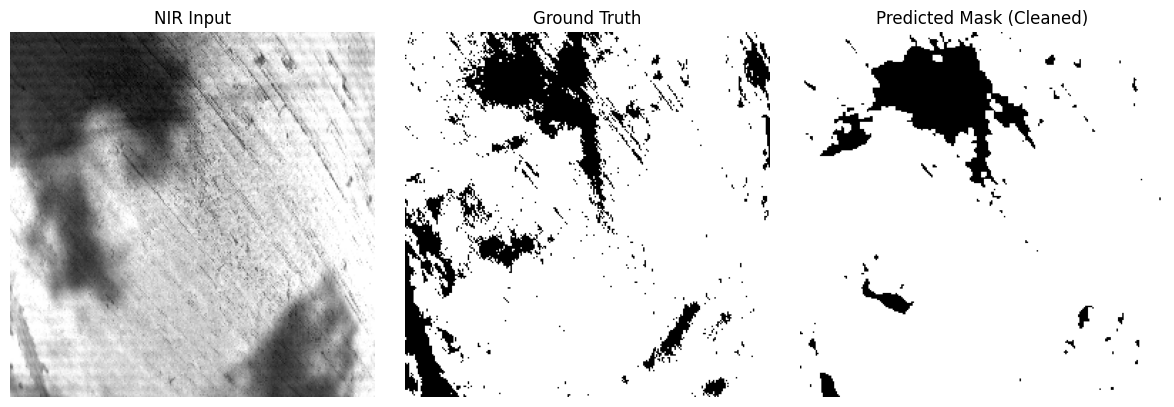

In [11]:
def visualize_prediction(model, dataset, idx=0):
    model.eval()
    img, true_mask = dataset[idx]
    img = img.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(img)  # shape: [1, 1, H, W]
        pred = torch.sigmoid(pred)[0, 0].cpu().numpy()

    # ✅ Apply post-processing to predicted mask
    pred_bin = (pred > 0.5).astype(np.uint8)
    kernel = np.ones((3, 3), np.uint8)
    pred_cleaned = cv2.morphologyEx(pred_bin, cv2.MORPH_OPEN, kernel)

    # ✅ Plot results
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("NIR Input")
    plt.imshow(img[0][0].cpu(), cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(true_mask[0], cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask (Cleaned)")
    plt.imshow(pred_cleaned, cmap="gray")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example use
val_dataset = VegetationDataset("/content/drive/MyDrive/DATASPLIT/VAL/NIR", "/content/drive/MyDrive/DATASPLIT/VAL/MASK", transform=transform)
visualize_prediction(model, val_dataset, idx=60)

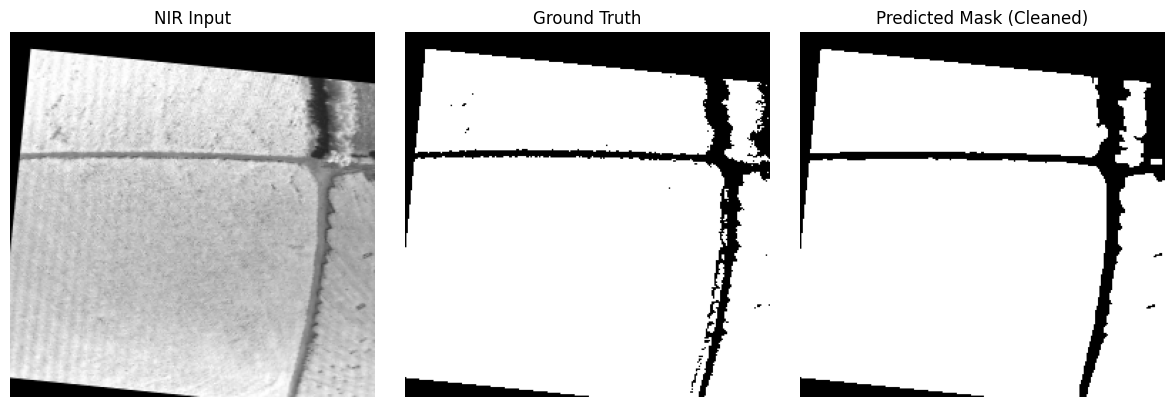

In [16]:
visualize_prediction(model, val_dataset, idx=6)

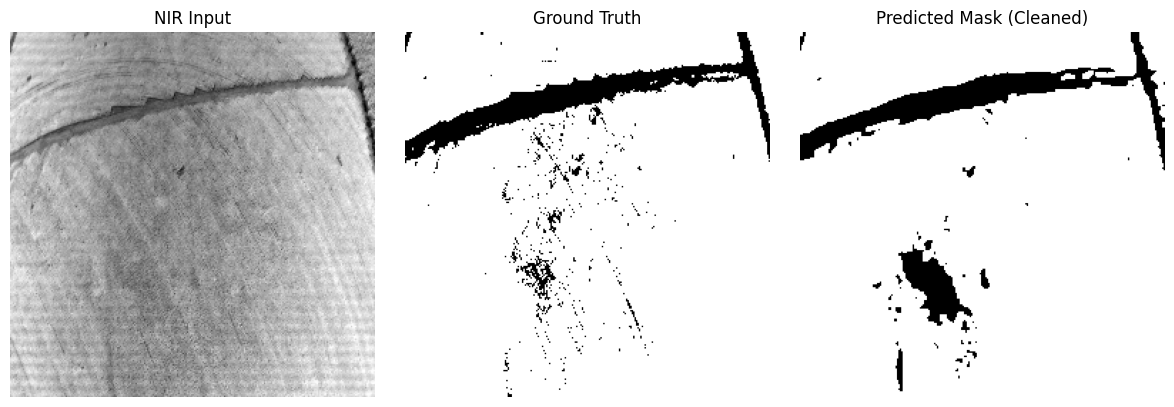

In [17]:
visualize_prediction(model, val_dataset, idx=25)

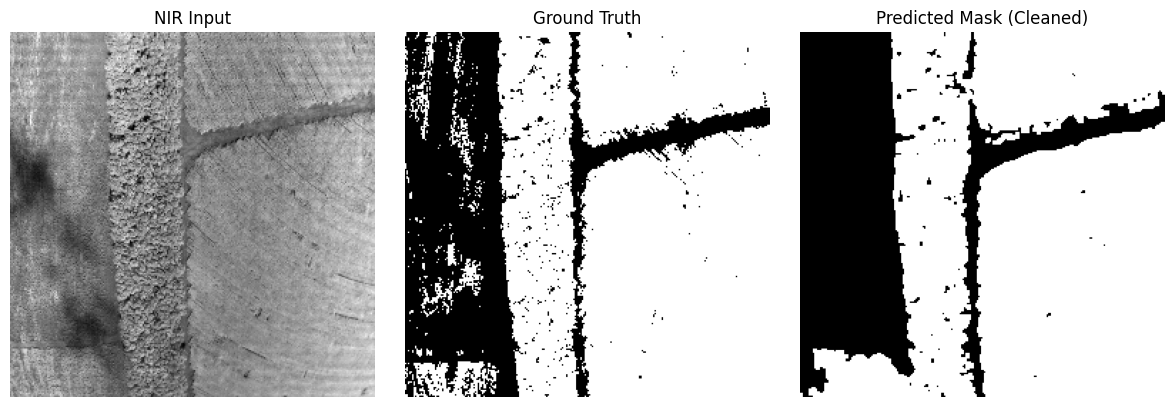

In [18]:
visualize_prediction(model, val_dataset, idx=12)

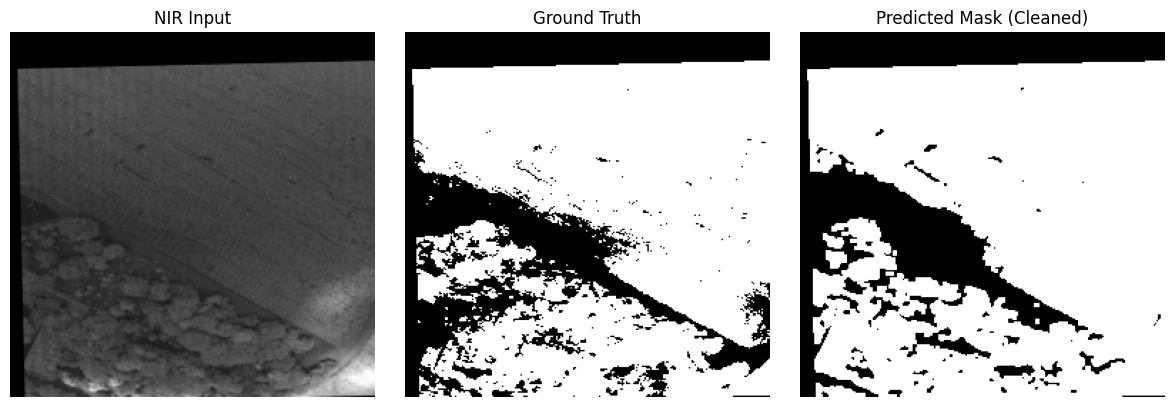

In [19]:
visualize_prediction(model, val_dataset, idx=87)

In [12]:
def dice_score(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    intersection = (pred * target).sum()
    return (2. * intersection) / (pred.sum() + target.sum() + 1e-8)

def iou_score(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return intersection / (union + 1e-8)

def pixel_accuracy(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    correct = (pred == target).float().sum()
    total = torch.numel(target)
    return correct / total


In [13]:
val_dataset = VegetationDataset("/content/drive/MyDrive/DATASPLIT/VAL/NIR", "/content/drive/MyDrive/DATASPLIT/VAL/MASK", transform=transform)
val_loader = DataLoader(val_dataset, batch_size=1)

def evaluate(model, dataloader):
    model.eval()
    dice_score = 0
    iou_score = 0
    pixel_acc = 0
    count = 0

    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = torch.sigmoid(model(imgs))  # apply sigmoid here
            preds = (preds > 0.5).float()

            # Flatten
            preds_flat = preds.view(-1)
            masks_flat = masks.view(-1)

            intersection = (preds_flat * masks_flat).sum()
            union = preds_flat.sum() + masks_flat.sum()

            dice = (2. * intersection) / (union + 1e-8)
            iou = intersection / (preds_flat + masks_flat - preds_flat * masks_flat).sum()
            acc = (preds_flat == masks_flat).float().mean()

            dice_score += dice.item()
            iou_score += iou.item()
            pixel_acc += acc.item()
            count += 1

    print(f"📊 Val -> Dice: {dice_score/count:.4f}, IoU: {iou_score/count:.4f}, Pixel Acc: {pixel_acc/count:.4f}")

evaluate(model, val_loader)


📊 Val -> Dice: 0.9312, IoU: 0.8751, Pixel Acc: 0.9035


In [ ]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import segmentation_models_pytorch as smp
import albumentations as A

# ===============================
# CONFIG
# ===============================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 256
MODEL_PATH = "/content/best_model100.pth"

TEST_NIR_DIR = "/content/drive/MyDrive/DATASPLIT/TEST/NIR"
TEST_MASK_DIR = "/content/drive/MyDrive/DATASPLIT/TEST/MASK"

# ===============================
# LOAD MODEL
# ===============================
model = smp.Unet(
    encoder_name="resnet34",
    in_channels=1,
    classes=1
).to(DEVICE)

model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# ===============================
# PREPROCESS (MATCH TRAINING)
# ===============================
transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.5,), std=(0.5,)),  # <- same as training
])

def preprocess_image(img):
    """Preprocess NIR image same as training."""
    img = transform(image=img)["image"]
    img = np.expand_dims(img, axis=0)  # (1, H, W)
    return torch.tensor(img, dtype=torch.float32).unsqueeze(0).to(DEVICE)  # (1, 1, H, W)

# ===============================
# POST-PROCESS
# ===============================
def clean_mask(mask, kernel_size=3):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    return cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

# ===============================
# TTA INFERENCE
# ===============================
def predict_with_tta(img_tensor):
    """Run inference with Test Time Augmentation (flip TTA)."""
    preds = []

    # Original
    pred = torch.sigmoid(model(img_tensor)).cpu().numpy()[0, 0]
    preds.append(pred)

    # Horizontal flip
    pred_h = torch.sigmoid(model(torch.flip(img_tensor, dims=[3]))).cpu().numpy()[0, 0]
    preds.append(np.flip(pred_h, axis=1))

    # Vertical flip
    pred_v = torch.sigmoid(model(torch.flip(img_tensor, dims=[2]))).cpu().numpy()[0, 0]
    preds.append(np.flip(pred_v, axis=0))

    # Average predictions
    final_pred = np.mean(preds, axis=0)
    return final_pred

# ===============================
# RUN INFERENCE LOOP
# ===============================
image_filenames = sorted(os.listdir(TEST_NIR_DIR))

for fname in tqdm(image_filenames):
    nir_path = os.path.join(TEST_NIR_DIR, fname)
    mask_name = fname.replace("_NIR.TIF", "_MASK.png")  # adjust if needed
    mask_path = os.path.join(TEST_MASK_DIR, mask_name)

    if not os.path.exists(mask_path):
        print(f"⚠️ Missing mask for {fname}, skipping.")
        continue

    # Load NIR + mask
    nir_img = cv2.imread(nir_path, cv2.IMREAD_GRAYSCALE)
    mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Preprocess
    nir_tensor = preprocess_image(nir_img)

    # Predict with TTA
    with torch.no_grad():
        pred_mask = predict_with_tta(nir_tensor)

    # Threshold + post-process
    pred_bin = (pred_mask > 0.5).astype(np.uint8)  # try adjusting to 0.4 if too strict
    pred_cleaned = clean_mask(pred_bin, kernel_size=3)

    # Resize for display
    nir_display = cv2.resize(nir_img, (IMG_SIZE, IMG_SIZE))
    mask_display = cv2.resize(mask_img, (IMG_SIZE, IMG_SIZE))

    # Plot
    plt.figure(figsize=(12, 4))
    plt.suptitle(fname, fontsize=10)

    plt.subplot(1, 3, 1)
    plt.title("NIR Image")
    plt.imshow(nir_display, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(mask_display, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask (Cleaned + TTA)")
    plt.imshow(pred_cleaned, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
